**load imports**


In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

**Set all the Constants**

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

**Import data into tensorflow dataset object**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='PlantVillage',
seed=123,
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[141.98236  115.98237  116.98237 ]
  [136.82382  110.823814 111.823814]
  [107.35246   81.35246   82.35246 ]
  ...
  [173.01381  155.01381  151.01381 ]
  [181.93741  163.93741  159.93741 ]
  [195.95111  177.95111  173.95111 ]]

 [[137.87445  111.87446  112.87446 ]
  [136.8248   110.82481  111.82481 ]
  [132.12982  106.129814 107.129814]
  ...
  [175.0646   157.0646   153.0646  ]
  [176.98244  158.98244  154.98244 ]
  [184.96088  166.96088  162.96088 ]]

 [[117.12743   91.12743   92.12743 ]
  [112.31633   86.31633   87.31633 ]
  [144.35968  118.35967  119.35967 ]
  ...
  [176.0387   158.0387   154.0387  ]
  [176.02917  158.02917  154.02917 ]
  [181.049    163.049    159.049   ]]

 ...

 [[107.330246  81.330246  80.330246]
  [145.66852  119.6685   118.6685  ]
  [126.09693  100.09693   99.09693 ]
  ...
  [162.9805   142.9805   141.9805  ]
  [166.96677  146.96677  145.96677 ]
  [170.96283  150.96283  149.96283 ]]

 [[114.9

In [6]:
len(class_names)


3

**Visualize some of the images from our dataset**


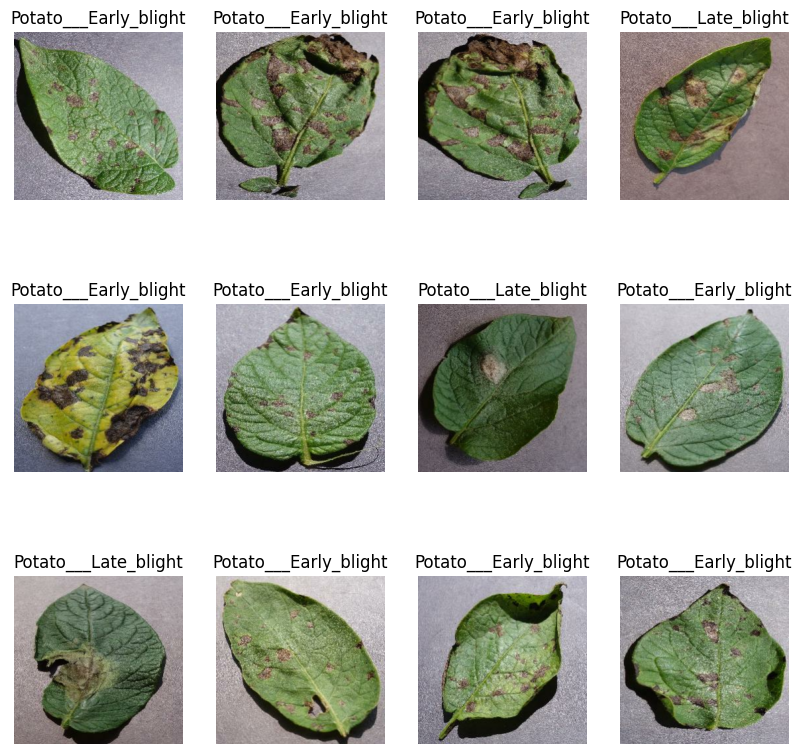

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)


68

In [9]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)


54

In [17]:
len(val_ds)


6

In [18]:
len(test_ds)


8

**Cache, Shuffle, and Prefetch the Dataset**

additional transformations is commonly used in TensorFlow to optimize the performance of the input pipeline when training machine learning models



In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**


Creating a Layer for Resizing and Normalization Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Data Augmentation**


Data Augmentation is needed was we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**


We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

**Compiling the Model**


We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 219s 4s/step - loss: 0.8793 - accuracy: 0.5556 - val_loss: 0.8296 - val_accuracy: 0.6354
Epoch 2/20
54/54 [==============================] - 198s 4s/step - loss: 0.6242 - accuracy: 0.7234 - val_loss: 0.5816 - val_accuracy: 0.7448
Epoch 3/20
54/54 [==============================] - 189s 3s/step - loss: 0.4324 - accuracy: 0.8194 - val_loss: 0.4182 - val_accuracy: 0.8021
Epoch 4/20
54/54 [==============================] - 189s 3s/step - loss: 0.3342 - accuracy: 0.8657 - val_loss: 0.6369 - val_accuracy: 0.7604
Epoch 5/20
54/54 [==============================] - 189s 3s/step - loss: 0.3470 - accuracy: 0.8611 - val_loss: 0.3020 - val_accuracy: 0.8594
Epoch 6/20
54/54 [==============================] - 189s 3s/step - loss: 0.2611 - accuracy: 0.9028 - val_loss: 0.3729 - val_accuracy: 0.8281
Epoch 7/20
54/54 [==============================] - 189s 3s/step - loss: 0.2271 - accuracy: 0.9097 - val_loss: 0.1568 - val_accuracy: 0.9375
Epoch 8/20
54

In [27]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 7s 400ms/step - loss: 0.3167 - accuracy: 0.8711


In [29]:
model.save("model.h5")


**Plotting the Accuracy and Loss Curves**


In [30]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.87925124168396,
 0.6241775155067444,
 0.4324229955673218,
 0.3341706693172455,
 0.34703752398490906]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

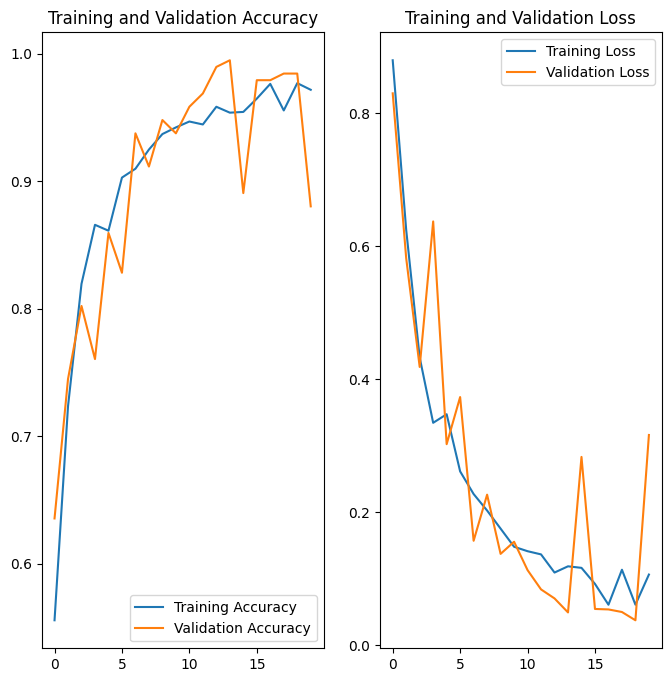

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Run prediction on a sample image**


In [34]:
model = tf.keras.models.load_model('model.h5')


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 638ms/step
predicted label: Potato___Early_blight


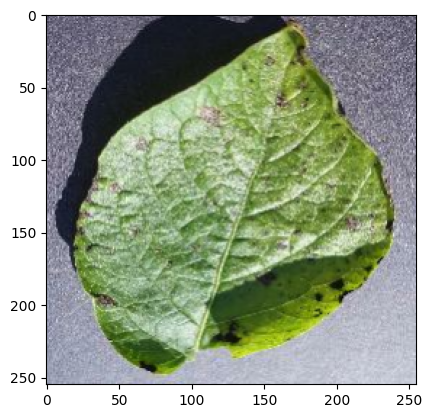

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**


In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


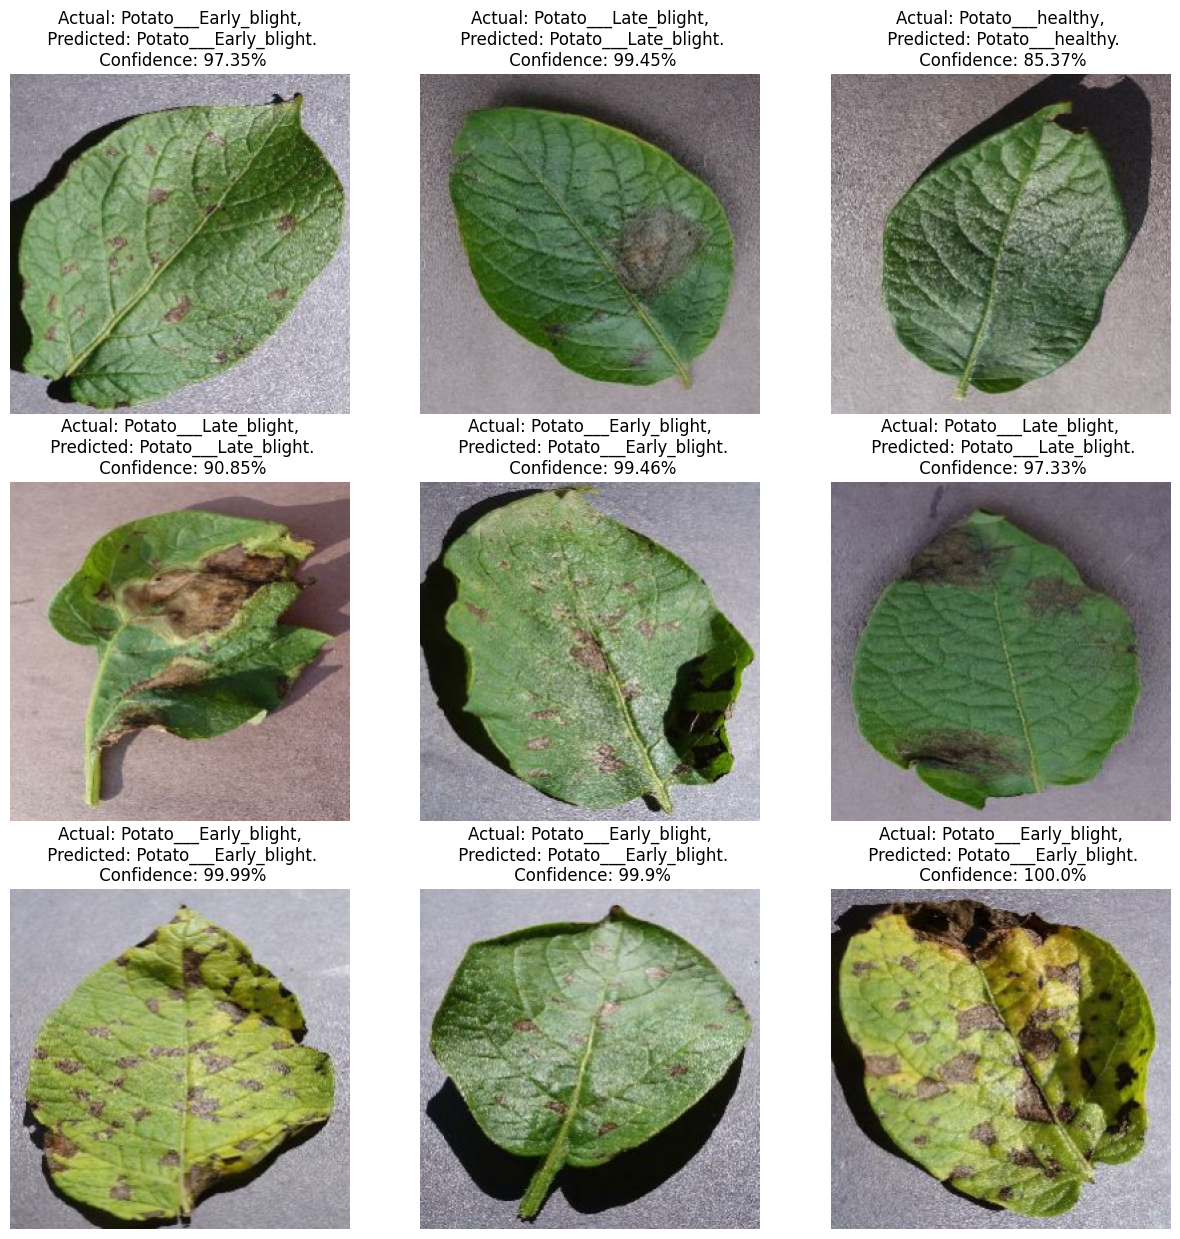

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")